# Working with syntactic information

This notebook introduces how to write and parse instructions to interpret dependency information for dependency-based models in the `nephosem` package.

In [1]:
import sys
nephosemdir = "../../nephosem/"
sys.path.append(nephosemdir)
from nephosem import PatternGraph, MacroGraph
mydir = f"./"

The instructions for the code to parse the dependency information in the corpus are coded as .graphml and .xml files, that are read to create `nephosem.PatternGraph` and `nephosem.MacroGraph` objects respectively.

In [2]:
path_graphml_fname = f"{mydir}/templates/LEMMAPATH.template.graphml"
path_patterns = PatternGraph.read_graphml(path_graphml_fname)

path_macro_fname = f"{mydir}/templates/LEMMAPATH.target-feature-macro.xml"
path_macros = MacroGraph.read_xml(path_macro_fname, path_patterns)

This is a fragment of the raw `path_patterns`, the .graphml file:

```xml
<graphml xmlns="http://graphml.graphdrawing.org/xmlns"
      xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
      xsi:schemaLocation="http://graphml.graphdrawing.org/xmlns
        http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd">
    <key id="n1" for="node" attr.name="lemma" attr.type="string">
        <default>(.+)</default>
    </key>
    <key id="n2" for="node" attr.name="pos" attr.type="string">
        <default>(\w+)</default>
    </key>
    <key id="e1" for="edge" attr.name="deprel" attr.type="string"/>
    <graph id="1" edgedefault="directed">
        <node id="1"></node>
        <node id="2"></node>
        <edge source="1" target="2">
            <data key="e1">\w+</data>
        </edge>
    </graph>
</graphml>
```

The structure is as follows: the main element is a `<graphml>` tag, that always stay the same, within which we have three `<key>` tags setting up the main elements we are now interested in: lemma and pos for the nodes, and deprel for the key. Inside them, the `<default>` tag lets us set up a default regex expression for filtering these items, but then we can make further specifications within the specific graphs. Afterwards, we can add as many `<graph>` tags as we want, each of them representing one pattern to match.

Each `<graph>` tag has an id (which is a string with a number) and a property `edgedefault="directed"`. Inside the `<graph>` tag we can have `<node>` and `<edge>` tags indicating the nodes (items) and edges (relationships) in the pattern. Here we have two nodes, 1 and 2, joined by an edge that goes from 1 (source attribute) to 2 (target attribute): node 1 is the head of node 2, e.g the verb for its direct object. We could specify that we want the direct object by filling in the `<data>` element within `<edge>` as `"dobj"` instead of `"\w+"`. Note that this `<data>` element has a `key` attribute with value `"e1"`, indicating that it points to the element defined by `<key id="e1" ...>`.
Within the nodes, we could have a similar `<data>` element with a `key` attribute and valeue `"n1"` if we want to filter by lemma or `"n2"` if we want to filter by part-of-speech.

The following is a fragment of the raw `path_macros`, the .xml file:

```xml
<?xml version="1.0" encoding="UTF-8"?>
<target-feature-list>
    <target-fmt>
        <node-fmt>
            <lemma group="1"/>
            <pos group="1"/>
            <fid group="1"/>
            <lid group="1"/>
            <string connector="/">lemma/pos/fid/lid</string>
        </node-fmt>
    </target-fmt>
    <feature-fmt>
        <node-fmt>
            <lemma group="1"/>
            <pos group="1"/>
            <string connector="/">lemma/pos</string>
        </node-fmt>
        <edge-fmt>deprel</edge-fmt>
    </feature-fmt>
    <target-feature-macro id="1">
        <sub-graph-pattern id="1"/>
        <target nodeID="1">
            <description>Empty</description>
        </target>
        <feature featureID="2">
            <description>Words that depend directly on the target.</description>
        </feature>
    </target-feature-macro>
</target-feature-list>
```

In this case, after the small xml preamble, we have the mail element `<target-feature-list>`, within which we find one `<target-fmt>` element to specify the format of the target, one `<feature-fmt>` tag to specify the format of the feature elements (the columns of our matrices), and as many `<target-feature-macro>` elements as we have templates/macros to describe.

In the `<target-fmt>` element, the `<node-fmt>` element gives instructions to capture the elements of a node and chain them. The `fid` and `lid` elements are only relevant at token-level. The same goes for `<feature-fmt>`, where a reference to the edge is included.

The `<target-feature-macro>` element has an attribute `"id"` (with a number as a string) and three child elements. The first element inside it, `<sub-graph-pattern>`, also has an attribute `"id"` that points to the id of a `<graph>` element in the .graphml file. It is unrelated to the `"id"` of the parent element. The `<target>` and `<feature>` elements point to the nodes in that `<graph>` that take the roles of node and feature. Here, because the `"nodeID"` attribute of `<target>` is `"1"`, the target is the head of the relationship in that graph; because the `"featureID"` attribute of `<feature>` is `"2"`, the feature is the dependent. Optionally, you can add a description of the item. With this format, the features will be the lemma/pos combination; if you exclude the `"featureID"` attribute altogether, the full template will become the feature (including dependency information).

Examples of application at type level can be found in [section 3.2](all-in-one.ipynb#3.2-Dependency-based) of the comprehensive tutorial; applications at token level are found in sections [5.2](all-in-one.ipynb#5.2.-Lemmarel) and [5.3](all-in-one.ipynb#5.3.-Lemmapath) for lemma/pos as features and [5.4](all-in-one.ipynb#5.4.-Deppath) for full path as feature.

The functions below let you visualize the graphs used for the patterns.

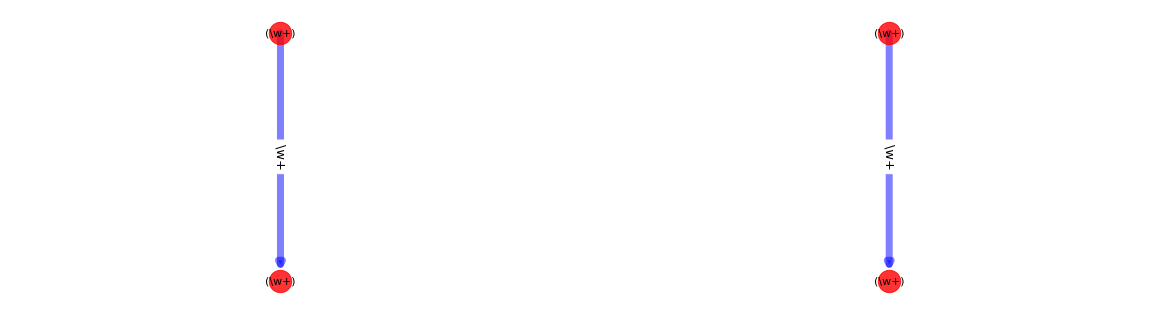

In [3]:
from nephosem.specutils.deputils import parse_pattern, draw_tree, draw_match, draw_labels, get_root
import matplotlib.pyplot as plt
%matplotlib inline
def plot_patterns(macros_list):
    plt.rcParams['figure.figsize'] = (20.0, 32.0)
    for i in range(len(macros_list)):
        plt.subplot(5, 2, i+1)
        draw_labels(macros_list[i].graph, v_labels='pos', e_labels='deprel')
    plt.show()

plot_patterns(path_macros)

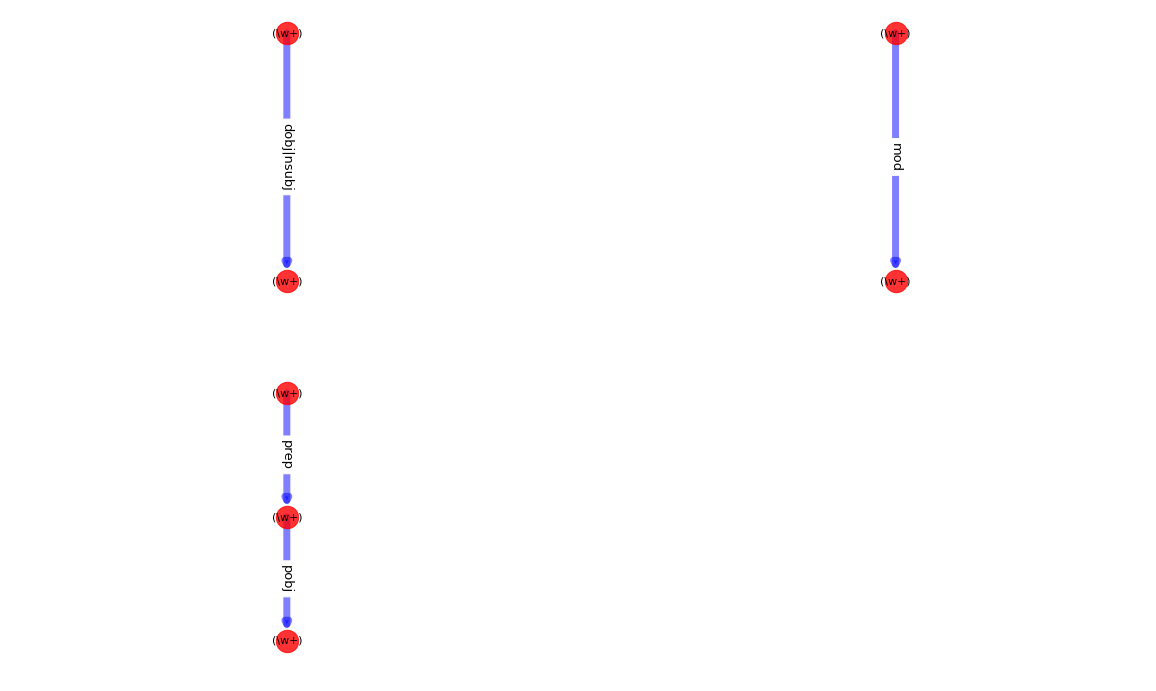

In [5]:
rel_graphml_fname = f"{mydir}/templates/LEMMAREL.template.graphml"
rel_patterns = PatternGraph.read_graphml(rel_graphml_fname)

rel_macro_fname = f"{mydir}/templates/LEMMAREL.target-feature-macro.xml"
rel_macros = MacroGraph.read_xml(rel_macro_fname, rel_patterns)
plot_patterns(rel_macros)